In [1]:
%pip install matplotlib
%pip install numpy
%pip install tqdm
%pip install --pre torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
from tqdm.notebook import tqdm

In [3]:
device = torch.device(
    "mps" if torch.backends.mps.is_available() 
    else "cuda" if torch.cuda.is_available()
    else "cpu")
print(f"Using device: {device}")

# set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: mps


In [4]:
# Scale images to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

useSingleDigit = False
if useSingleDigit:
    num = 2

    trainset.data = trainset.data[trainset.targets == num]
    trainset.targets = trainset.targets[trainset.targets == num]

    valset.data = valset.data[valset.targets == num]
    valset.targets = valset.targets[valset.targets == num]

batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

torch.Size([128, 1, 28, 28])
1 2 8 5 2 6 9 9


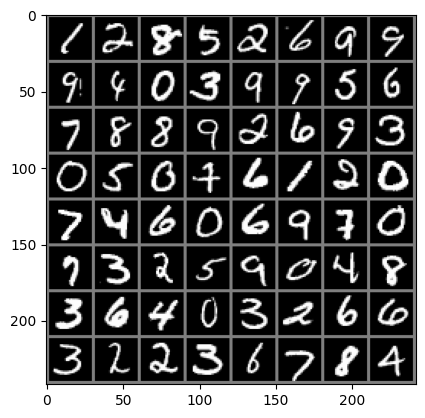

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize from [-1, 1] to [0, 1]
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
images = images[0:64]

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{labels[j]}' for j in range(8)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

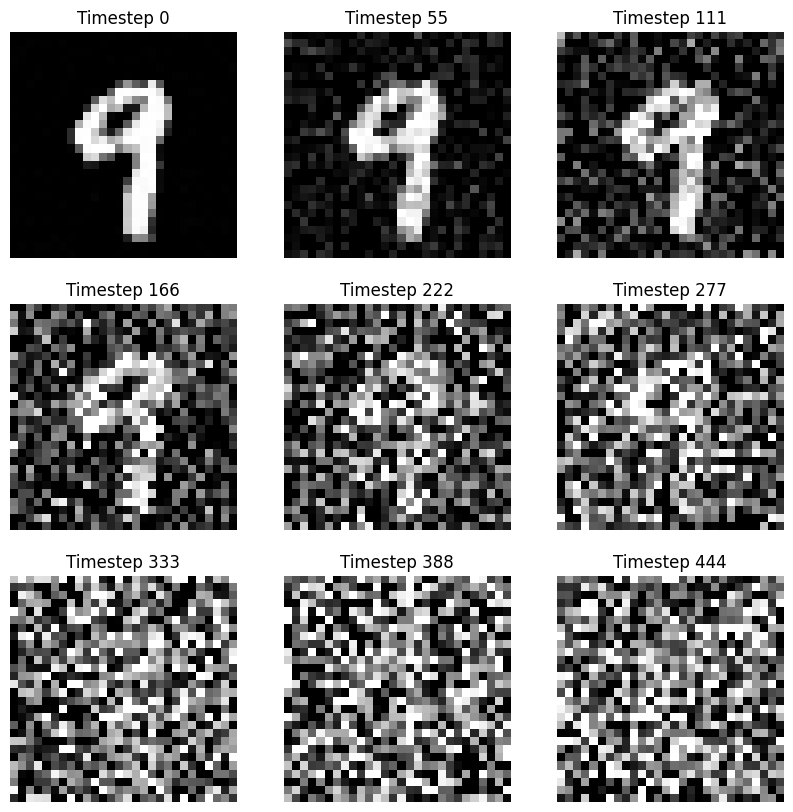

In [7]:
T = 500 # Total number of timesteps
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)

# Pre-calculate terms for the forward process q(x_t | x_{t-1}) and q(x_t | x_0)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # Add alpha_cumprod_0 = 1
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # Used in the reverse process

# Function to get the noisy image x_t at a specific timestep t, given the original image x_0
# q(x_t | x_0) = N(x_t; sqrt(alpha_cumprod_t) * x_0, (1 - alpha_cumprod_t) * I)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

# test
dataiter = iter(trainloader)
images, _ = next(dataiter)
x_start = images.to(device)

# Sample timesteps
t = torch.randint(0, T, (x_start.shape[0],), device=device).long()

# Generate noise and noisy images
noise = torch.randn_like(x_start)
x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

# Display some noisy images at different timesteps
base_idx = 0
orig = x_start[base_idx:base_idx+1]

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    t = torch.tensor([i * T // 9], device=device)
    img_t = q_sample(orig, t).clamp(-1, 1)
    imshow(torchvision.utils.make_grid(img_t.cpu()))
    ax.set_title(f"Timestep {i * T // 9}")
    ax.axis("off")
plt.show()

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import math

# --- Sinusoidal Positional Embedding --- 
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# --- Building Block: Basic Residual Block ---
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, dropout=0.1):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.norm1 = nn.LayerNorm(in_ch)
        self.norm2 = nn.LayerNorm(out_ch)
        self.act   = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch,  out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.dropout = nn.Dropout(dropout)
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()

    def forward(self, x, t):
        t_emb = self.act(self.time_mlp(t))
        h = x.permute(0,2,3,1)
        h = self.norm1(h)
        h = h.permute(0,3,1,2)
        h = self.act(h)
        h = self.conv1(h)
        h = h + t_emb.unsqueeze(-1).unsqueeze(-1)
        h = h.permute(0,2,3,1)
        h = self.norm2(h)
        h = h.permute(0,3,1,2)
        h = self.act(h)
        h = self.dropout(h)
        h = self.conv2(h)
        return h + self.res_conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, img_channels=1, time_emb_dim=128, num_classes=10):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.num_classes = num_classes

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.label_emb = nn.Embedding(num_classes, time_emb_dim)

        # Downsampling (smaller channels)
        self.conv0 = nn.Conv2d(img_channels,  32, 3, padding=1)
        self.res1  = ResBlock(32,  32,  time_emb_dim)
        self.down1 = nn.Conv2d(32,  64, 4, stride=2, padding=1)
        self.res2  = ResBlock(64,  64,  time_emb_dim)
        self.down2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.res3  = ResBlock(128, 128, time_emb_dim)

        # Bottleneck
        self.bot1 = ResBlock(128, 128, time_emb_dim)
        self.bot2 = ResBlock(128, 128, time_emb_dim)

        # Upsampling
        self.up1  = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.res4 = ResBlock(64, 64, time_emb_dim)
        self.up2  = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.res5 = ResBlock(32, 32, time_emb_dim)

        self.out = nn.Conv2d(32, img_channels, 1)

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t)
        y_emb = self.label_emb(y)
        emb   = t_emb + y_emb

        x0 = self.conv0(x)
        x0 = self.res1(x0, emb)
        x1 = self.down1(x0)
        x1 = self.res2(x1, emb)
        x2 = self.down2(x1)
        x2 = self.res3(x2, emb)

        b = self.bot1(x2, emb)
        b = self.bot2(b, emb)

        u1 = self.up1(b) + x1
        u1 = self.res4(u1, emb)
        u2 = self.up2(u1) + x0
        u2 = self.res5(u2, emb)

        return self.out(u2)

# Instantiate the model and move it to the device
model = ConditionalUNet().to(device)
print(f"Model parameter count: {sum(p.numel() for p in model.parameters())}")

# Test with a dummy input
dummy_x = torch.randn(4, 1, 28, 28, device=device) # Batch of 4 noisy images
dummy_t = torch.randint(0, T, (4,), device=device).long() # Batch of 4 timesteps
dummy_y = torch.randint(0, 10, (4,), device=device).long() # Batch of 4 labels
pred_noise = model(dummy_x, dummy_t, dummy_y) # Forward pass
print(f"Output shape: {pred_noise.shape}") # Should be (4, 1, 28, 28)

Model parameter count: 1492929
Output shape: torch.Size([4, 1, 28, 28])


In [9]:
# load the model weights if available

load_model = True
if load_model:
    model.load_state_dict(torch.load("conditional_diffusion_model.pth", map_location=device))

In [11]:
import torch.optim as optim

# Loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-4)

# Training parameters
epochs = 5
load_best_at_end = True

# early stopping parameters
early_stopping_patience = 4
early_stopping_counter = 0
best_val_loss = float('inf')

In [12]:
# Training loop
for epoch in range(epochs):
    model.train() # Set model to training mode
    total_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for step, (batch, labels) in enumerate(progress_bar):
        optimizer.zero_grad() # Reset gradients

        x_start = batch.to(device)
        batch_size = x_start.shape[0]

        # 1. Sample timesteps t for the batch
        t = torch.randint(0, T, (batch_size,), device=device).long()

        # 2. Sample noise
        noise = torch.randn_like(x_start)

        # 3. Create noisy images x_t
        x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

        # 4. Get model prediction (predicted noise)
        predicted_noise = model(x_noisy, t, labels.to(device))

        # 5. Calculate loss
        loss = loss_fn(noise, predicted_noise)

        # 6. Backpropagate and update weights
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    # Calculate average loss
    avg_loss = total_loss / len(trainloader)

    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for val_batch, val_labels in valloader:
            val_batch = val_batch.to(device)
            val_labels = val_labels.to(device)

            t = torch.randint(0, T, (val_batch.size(0),), device=device).long()

            noise = torch.randn_like(val_batch)

            x_noisy = q_sample(x_start=val_batch, t=t, noise=noise)
            predicted_noise = model(x_noisy, t, val_labels)
            val_loss = loss_fn(noise, predicted_noise)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(valloader)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0

        torch.save(model.state_dict(), "conditional_diffusion_model.pth")
    else:
        early_stopping_counter += 1
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, patience: {early_stopping_counter}/{early_stopping_patience}")
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch+1}, current val loss: {avg_val_loss:.4f}, best val loss: {best_val_loss:.4f}")
        break
    
if load_best_at_end:
    model.load_state_dict(torch.load("conditional_diffusion_model.pth", map_location=device))
    print("Loaded best model weights.")

print("Training finished.")

Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 0.0318, Val Loss: 0.0306, patience: 0/4


Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 0.0322, Val Loss: 0.0314, patience: 1/4


Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.0322, Val Loss: 0.0309, patience: 2/4


Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Train Loss: 0.0320, Val Loss: 0.0316, patience: 3/4


Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.0316, Val Loss: 0.0305, patience: 0/4
Loaded best model weights.
Training finished.


In [13]:
@torch.no_grad() # No need to track gradients during sampling
def p_sample(model, x, t, t_index, y):
    """
    Performs one step of the reverse diffusion process (p(x_{t-1} | x_t)).
    """
    betas_t = betas[t_index].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t_index].reshape(-1, 1, 1, 1)
    sqrt_recip_alphas_t = sqrt_recip_alphas[t_index].reshape(-1, 1, 1, 1)

    # Use our model (noise predictor) to predict the mean
    predicted_noise = model(x, t, y)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = posterior_variance[t_index].reshape(-1, 1, 1, 1)
        noise = torch.randn_like(x)
    
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape, y):
    """
    Samples a batch of images by iterating through the reverse diffusion process.
    """
    batch_size = shape[0]
    # Start from pure noise (for x_T)
    img = torch.randn(shape, device=device)
    imgs = []

    print("Sampling...")
    for i in tqdm(reversed(range(0, T)), desc='Sampling loop time step', total=T):
        t = torch.full((batch_size,), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t, i, y)
    imgs.append(img.cpu()) # Store final image
    return imgs

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

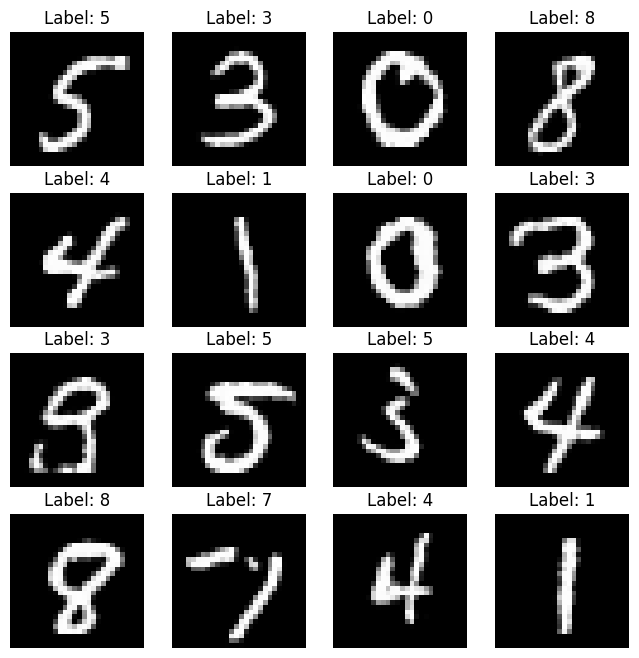

In [15]:
# --- Generate Samples ---
model.eval() # Set model to evaluation mode

num_images_to_generate = 16

digit = -1
y = None
if digit == -1:
    y = torch.randint(0, 10, (num_images_to_generate,), device=device, dtype=torch.long) # Random digits
else:
    y = torch.full((num_images_to_generate,), digit, device=device, dtype=torch.long) # Generate images of the digit

generated_images = p_sample_loop(model, shape=(num_images_to_generate, 1, 28, 28), y=y)
generated_images[-1] = torch.clamp(generated_images[-1], -1, 1) # Clamp to [-1, 1]

# Print sample labels in a grid
plt.figure(figsize=(8, 8))
for i in range(num_images_to_generate):
    ax = plt.subplot(4, 4, i + 1)
    ax.set_title(f"Label: {y[i].item()}")
    imshow(torchvision.utils.make_grid(generated_images[-1][i:i+1].cpu()))
    ax.axis("off")
plt.show()

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            # shape: (1, 28, 28)
            nn.Conv2d(1, 8, kernel_size=5),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # shape: (8, 24, 24)
            nn.MaxPool2d(kernel_size=2, stride=1),
            # shape: (8, 23, 23)
            nn.Conv2d(8, 20, kernel_size=4),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            # shape: (20, 20, 20)
            nn.MaxPool2d(kernel_size=2, stride=2),
            # shape: (20, 10, 10)
            nn.Conv2d(20, 20, kernel_size=2, stride=2),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            # shape: (20, 5, 5)
            nn.Flatten(),
            nn.Linear(20 * 5 * 5, 124),
            nn.BatchNorm1d(124),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(124, 92),
            nn.BatchNorm1d(92),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(92, 10)
        )

    def forward(self, x):
        x = self.seq(x)
        return F.log_softmax(x, dim=1)
        

classifier = Net().to(device)
print(classifier)

Net(
  (seq): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 20, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(20, 20, kernel_size=(2, 2), stride=(2, 2))
    (9): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=500, out_features=124, bias=True)
    (13): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.25, inplace=False)
    (16): Linear(in_features=124, out_features=92, bias=True)


In [17]:
try:
    classifier.load_state_dict(torch.load("mnist copy-9951.pth"))
    print("model loaded")
except Exception as e:
    raise Exception("model not loaded") from e

model loaded


In [18]:
test_sample_size = 100

In [20]:
# generate random labels

y = torch.randint(0, 10, (test_sample_size,), device=device, dtype=torch.long) # Random digits
# generate images
generated_images = p_sample_loop(model, shape=(test_sample_size, 1, 28, 28), y=y)
gen = (generated_images[-1] + 1) / 2

# run the classifier on the generated images
classifier.eval() # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for i in range(test_sample_size):
        img = gen[i:i+1].to(device)
        label = y[i:i+1].to(device)
        output = classifier(img)
        _, predicted = torch.max(output.data, 1)
        total += 1
        correct += (predicted == label).sum().item()
print(f"Accuracy of the generated images: {100 * correct / total:.2f}%")

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Accuracy of the generated images: 96.00%


In [21]:
def generate_quality_samples(num, req_images, classifier, req_certainty=0.9999, limit_certainty=1, batch_size = 16, max_iters = 20):
    good_images = []
    iters = 0
    while len(good_images) < req_images and iters < max_iters:
        y = torch.full((batch_size,), num, device=device, dtype=torch.long) # Generate images of the digit
        generated_images = p_sample_loop(model, shape=(batch_size, 1, 28, 28), y=y)
        gen = (generated_images[-1] + 1) / 2
        gen = gen.clamp(0, 1) # Clamp to [0, 1]
        gen = gen.to(device)

        # run the classifier on the generated images
        classifier.eval() # Set model to evaluation mode
        with torch.no_grad():
            out = classifier(gen)

            probs = torch.exp(out)
            pred_labels = torch.argmax(probs, dim=1)
            certs = torch.max(probs, dim=1).values
            for i in range(batch_size):
                if certs[i] >= req_certainty and pred_labels[i] == num and certs[i] <= limit_certainty:
                    good_images.append((gen[i:i+1].cpu() * 2 - 1, y[i:i+1].cpu()))
        if len(good_images) >= req_images:
            print(f"Generated {len(good_images)} images, stopping generation.")
        else:
            print(f"Generated {len(good_images)} images, generating more...")
        iters += 1

    return good_images

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 15 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 31 images, stopping generation.


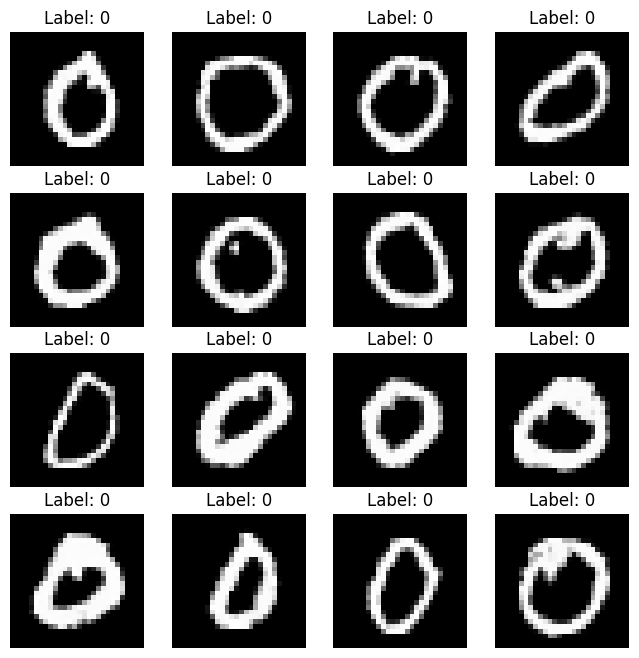

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 12 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 27 images, stopping generation.


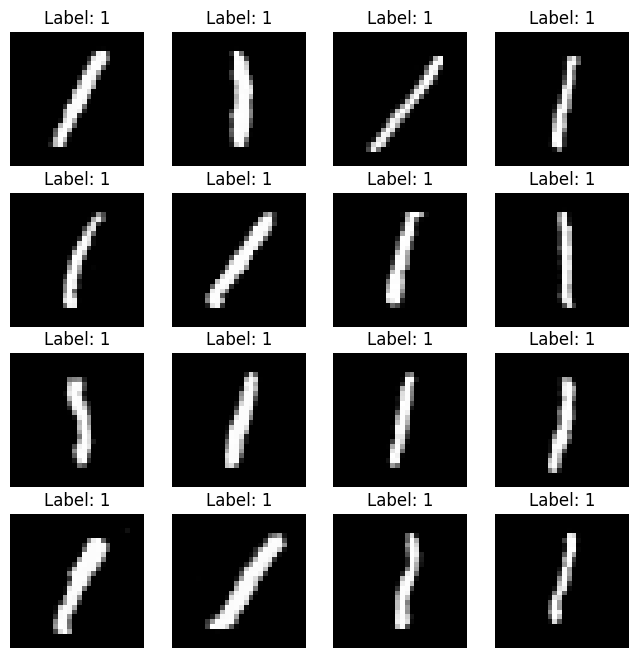

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 6 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 16 images, stopping generation.


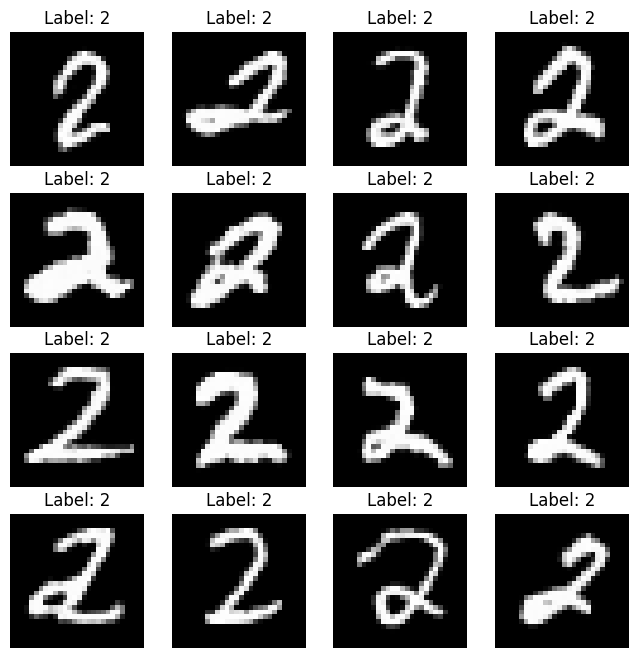

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 12 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 23 images, stopping generation.


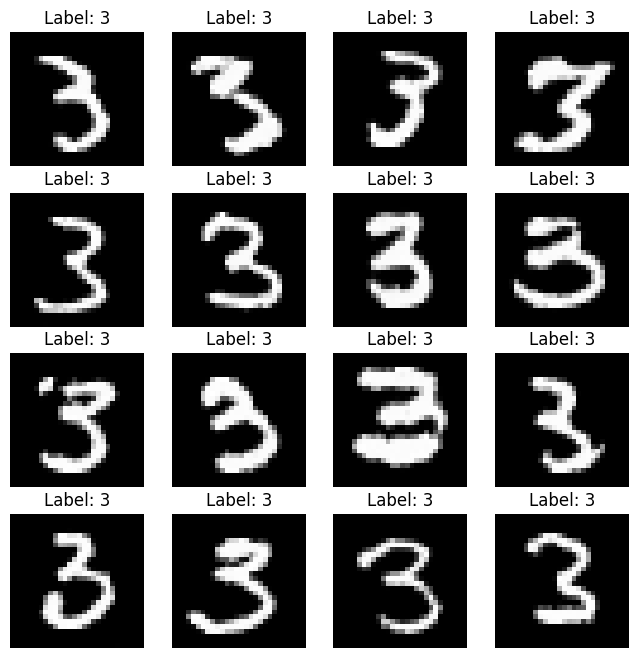

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 13 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 23 images, stopping generation.


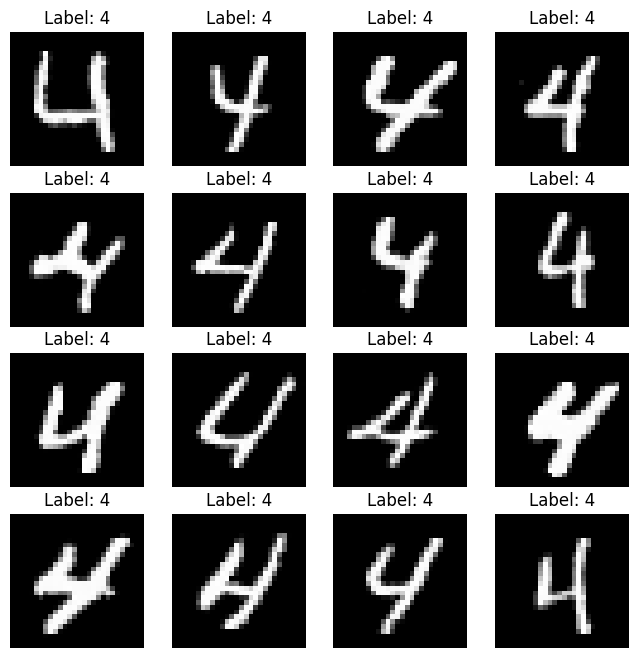

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 10 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 20 images, stopping generation.


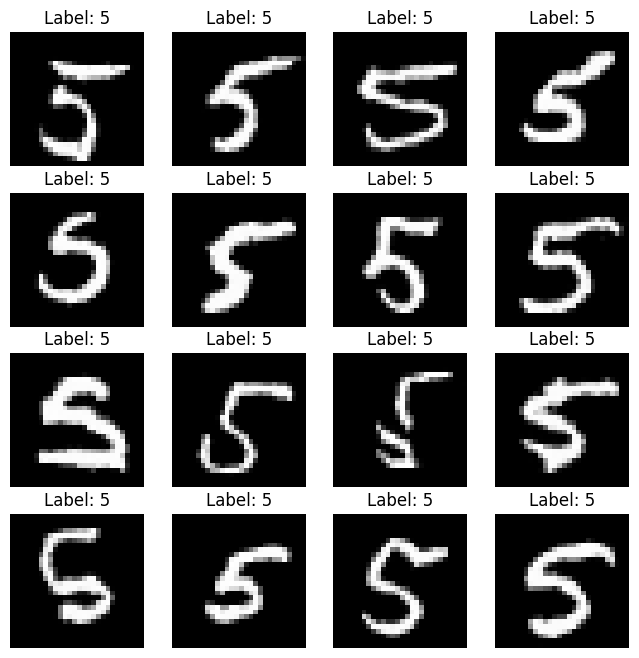

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 13 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 24 images, stopping generation.


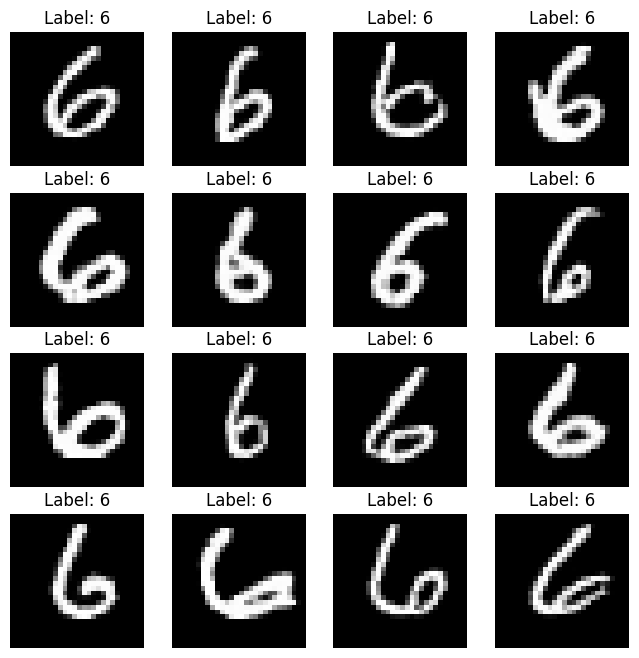

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 4 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 9 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 16 images, stopping generation.


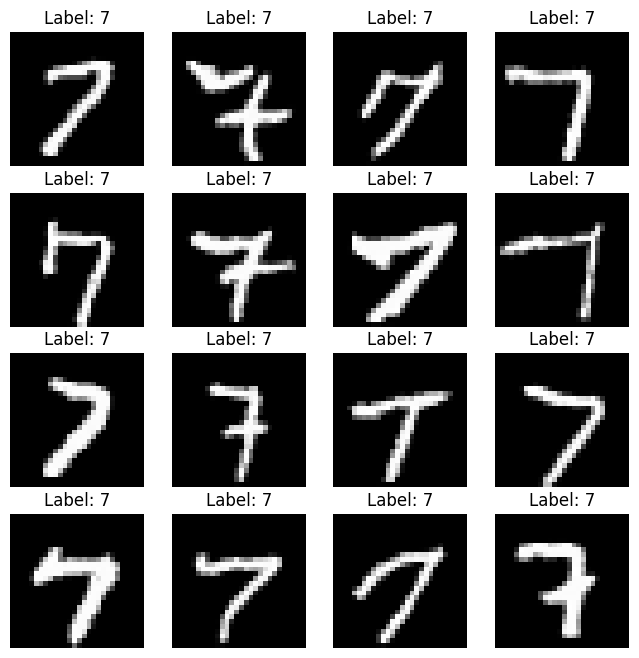

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 8 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 16 images, stopping generation.


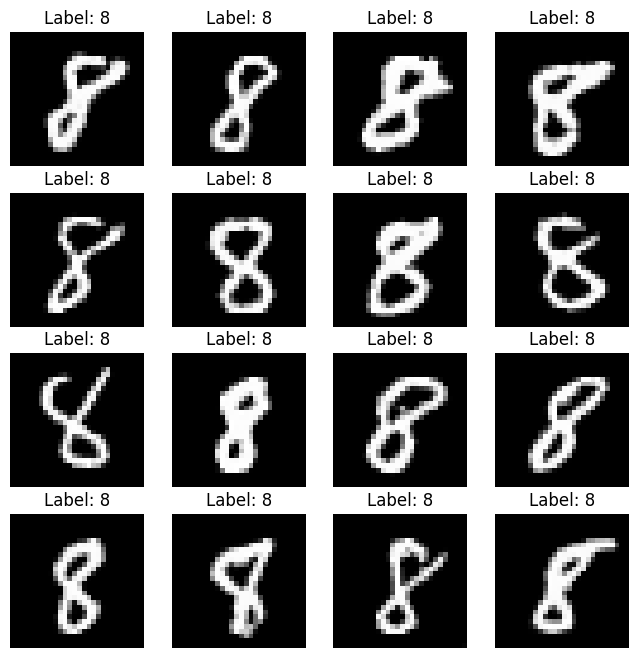

Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 8 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 15 images, generating more...
Sampling...


Sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 19 images, stopping generation.


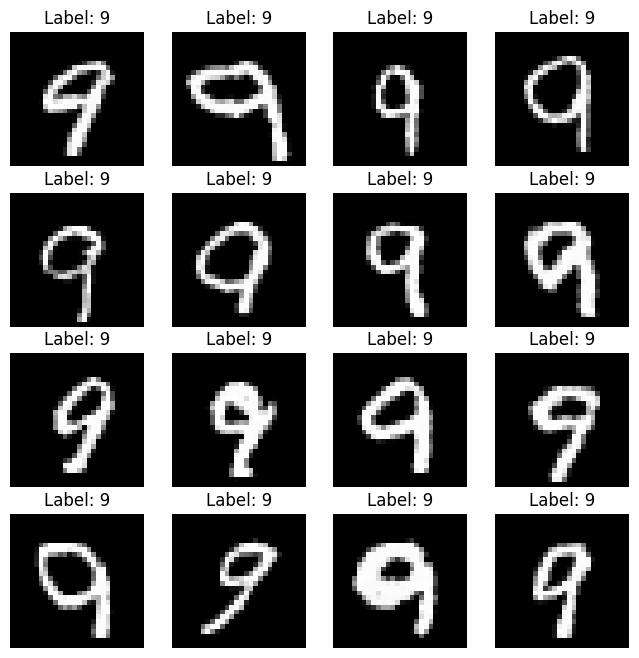

In [27]:
def generate_and_show(num, classifier, count=16, req_certainty=0.9, limit_certainty=0.99):
    good_images = generate_quality_samples(num, count, classifier)

    # Show images
    plt.figure(figsize=(8, 8))
    for i in range(min(len(good_images), count)):
        ax = plt.subplot(4, 4, i + 1)
        imshow(torchvision.utils.make_grid(good_images[i][0].cpu()))
        ax.set_title(f"Label: {good_images[i][1][0]}")
        ax.axis("off")
    plt.show()

for i in range(10):
    generate_and_show(i, classifier, count=16)